#### Checking Python version

In [1]:
!python -V

Python 3.8.8


This is the same code present in `persistency_base_model - modified data3.ipynb`. I have just copied the notebook and renamed it. In this notebook, I am using the new data `master_data - modified3.csv` which I have renamed to `master_data_final2.csv` in this folder

#### Importing libraries

In [2]:
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from datetime import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
%matplotlib inline
import seaborn as sns

from feature_engine import encoding as ce
from feature_engine import imputation as mdi
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import sklearn.metrics as metrics

#### Importing mlflow and setting tracking uri

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("persistency-prediction-experiment")

<Experiment: artifact_location='./mlruns/1', creation_time=1673260171550, experiment_id='1', last_update_time=1673260171550, lifecycle_stage='active', name='persistency-prediction-experiment', tags={}>

#### Importing data

In [4]:
INPUT_FILEPATH = 'data'
INPUT_FILENAME = 'master_data_final2.csv'

INDEX = 'policy_number'
DATE_COLS = ['proposal_received_date', 'policy_issue_date', 'agent_dob', 'agent_doj']
NA_VALUES = ['', 'NA', 'N/A', 'NULL', 'null', '?', '*', '#N/A', '#VALUE!']
DTYPE_DICT = {'zipcode': 'str', 'agent_code': 'str'} ## These columns should be string

In [5]:
def load_data(INPUT_FILEPATH, INPUT_FILENAME):
    input_df = pd.read_csv(os.path.join(INPUT_FILEPATH, INPUT_FILENAME),
                      index_col = INDEX,
                      na_values = NA_VALUES,
                      parse_dates = DATE_COLS,
                      dayfirst = True,
                      dtype = DTYPE_DICT)
                    
    return input_df

In [6]:
input_df = load_data(INPUT_FILEPATH, INPUT_FILENAME)
input_df.head(10)

,proposal_received_date,policy_issue_date,owner_age,owner_gender,marital_status,num_nominee,smoker,medical,education,occupation,experience,income,zipcode,county,state,negative_zipcode,family_member,existing_num_policy,has_critical_health_history,policy_term,payment_freq,annual_premium,sum_insured,agent_code,agent_dob,agent_doj,agent_status,agent_education,agent_age,agent_tenure_days,agent_persistency,last_6_month_submissions,average_premium,is_reinstated,prev_persistency,num_complaints,target_completion_perc,has_contacted_in_last_6_months,credit_score,lapse
policy_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2020-09-08,2020-09-08,22,Female,Single,1,No,No,Graduate,Sales,1,50000,19111,Philadelphia County,PA,0,1,0,0,25,Annually,377,580019,60503862,1997-07-03,2020-08-31,Active,Graduate,23,8,0.76,35,377,1,0.67,1,0.98,1,762,0
2,2020-08-24,2020-08-26,33,Female,Single,1,No,No,High School,Housewife,0,0,7764,Monmouth County,NJ,0,1,0,0,20,Quaterly,671,829002,60422713,1980-03-28,2018-05-17,Active,High School,40,830,0.87,54,671,0,0.00,4,0.90,1,794,0
3,2020-08-24,2020-08-24,29,Female,Married,1,No,No,Lt High School,Other Service,13,100000,26335,Braxton County,WV,0,2,1,0,10,Annually,210,659027,60450939,1978-06-25,2019-02-25,Inactive,Some College,42,546,0.93,0,579,0,0.00,8,0.93,1,800,0
4,2020-08-24,2020-08-24,57,Male,Divorced,1,No,Yes,Graduate,Military,36,242286,98241,Skagit County,WA,0,3,0,0,15,Annually,1863,612890,60394377,1993-05-05,2017-07-10,Active,Graduate,27,1141,0.78,29,1333,1,0.72,8,0.95,1,850,0
5,2020-08-24,2020-08-25,32,Female,Divorced,1,No,No,Post Graduate,Teacher,8,20434,78160,Wilson County,TX,0,1,1,0,20,Annually,730,879549,60491531,1967-12-05,2020-03-20,Active,Graduate,53,157,0.89,44,652,0,0.00,8,0.89,0,745,1
6,2020-08-24,2020-08-29,27,Male,Single,1,Yes,Yes,Graduate,Accountant,6,65000,15938,Cambria County,PA,0,1,0,0,20,Annually,941,862056,60408239,1986-06-05,2017-11-30,Active,Graduate,34,998,0.75,26,1890,0,0.00,8,0.83,0,720,1
7,2020-08-24,2020-08-24,39,Male,Married,1,No,No,High School,Govt Service,21,116539,28707,Jackson County,NC,0,3,0,1,10,Annually,331,529537,60476244,1984-11-03,2019-10-22,Active,Lt High School,36,307,0.81,45,926,0,0.00,13,0.92,0,686,0
8,2020-08-24,2020-09-30,39,Female,Widowed,1,Yes,Yes,Graduate,Shop Owner,18,56924,60129,DeKalb County,IL,0,1,0,1,15,Monthly,566,501114,60237645,NaT,2012-08-23,Active,High School,36,2923,0.98,60,1119,0,0.00,8,0.95,0,838,0
9,2020-08-24,2020-08-26,28,Male,Married,1,No,No,Graduate,IT Service,7,64762,33759,Pinellas County,FL,0,3,0,0,25,Annually,477,465743,60221480,1964-10-26,2011-10-13,Active,Lt High School,56,3238,0.70,40,842,0,0.00,27,0.88,1,773,0


#### Checking data info

In [7]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44948 entries, 1 to 44948
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   proposal_received_date          44948 non-null  datetime64[ns]
 1   policy_issue_date               44948 non-null  datetime64[ns]
 2   owner_age                       44948 non-null  int64         
 3   owner_gender                    44948 non-null  object        
 4   marital_status                  44948 non-null  object        
 5   num_nominee                     44948 non-null  int64         
 6   smoker                          44948 non-null  object        
 7   medical                         44948 non-null  object        
 8   education                       44948 non-null  object        
 9   occupation                      44948 non-null  object        
 10  experience                      44948 non-null  int64         
 11  in

In [8]:
input_df.columns

Index(['proposal_received_date', 'policy_issue_date', 'owner_age',
       'owner_gender', 'marital_status', 'num_nominee', 'smoker', 'medical',
       'education', 'occupation', 'experience', 'income', 'zipcode', 'county',
       'state', 'negative_zipcode', 'family_member', 'existing_num_policy',
       'has_critical_health_history', 'policy_term', 'payment_freq',
       'annual_premium', 'sum_insured', 'agent_code', 'agent_dob', 'agent_doj',
       'agent_status', 'agent_education', 'agent_age', 'agent_tenure_days',
       'agent_persistency', 'last_6_month_submissions', 'average_premium',
       'is_reinstated', 'prev_persistency', 'num_complaints',
       'target_completion_perc', 'has_contacted_in_last_6_months',
       'credit_score', 'lapse'],
      dtype='object')

#### Target variable distribution

In [9]:
input_df['lapse'].value_counts()/len(input_df)*100

0    64.683634
1    35.316366
Name: lapse, dtype: float64

#### Creating feature: time_to_issue

In [10]:
def create_time_to_issue(df) -> pd.DataFrame:
    df['time_to_issue'] = (df['policy_issue_date'] - df['proposal_received_date']).dt.days

    return df

In [11]:
input_df = create_time_to_issue(input_df)
input_df['time_to_issue'].describe()

count    44948.000000
mean         5.640451
std         11.153843
min          0.000000
25%          0.000000
50%          1.000000
75%          7.000000
max        494.000000
Name: time_to_issue, dtype: float64

#### Creating feature: prem_to_income_ratio

In [12]:
def create_prem_to_income_ratio(df) -> pd.DataFrame:
    df['prem_to_income_ratio'] = np.where(df['income'] == 0, 0, (df['annual_premium']/df['income']))

    return df

In [13]:
input_df = create_prem_to_income_ratio(input_df)
input_df['prem_to_income_ratio'].describe()

count    44948.000000
mean         0.016824
std          0.025457
min          0.000000
25%          0.004170
50%          0.008553
75%          0.017717
max          0.200000
Name: prem_to_income_ratio, dtype: float64

## --------------------------------------------------------------------------------------------------------------------------------

The objective of this exercise is to create a demoable solution (maybe not the best possible one, given the augmented data). Hence, we are not going to deep dive into EDA and hypothesis testing. Instead, we will focus on building the ML product using different technologies. 

## --------------------------------------------------------------------------------------------------------------------------------

#### Columns to remove

In [14]:
COLS_TO_REM = ['proposal_received_date','policy_issue_date', 'zipcode', 'county', 'state', 'agent_code', 'agent_dob', 'agent_doj']

- `proposal_received_date`: Derived `time_to_issue` from this column
- `policy_issue_date`: Derived `time_to_issue` from this column
- `zipcode`: Too many values, high cardinality
- `county`: Too many values, high cardinality
- `state`: Too many values, high cardinality
- `agent_code`: Id column
- `agent_dob`: Derived `agent_age` from this column
- `agent_doj`: Derived `agent_tenure_days` from this column

In [15]:
def filter_df(df, COLS_TO_REM) -> pd.DataFrame:
    df = df.drop(COLS_TO_REM, axis = 1)
    return df

In [16]:
temp_df = filter_df(input_df, COLS_TO_REM)
temp_df.shape

(44948, 34)

In [17]:
input_df.shape

(44948, 42)

## Feature Engineering Steps

#### Missing Value Imputation

We have only one column where missing value is present. `agent_persistency`. Impute missing value with median

In [18]:
agent_persistency_missing_perc = round(temp_df['agent_persistency'].isnull().mean()*100,2)

print(f'Total missing percentage of column agent_persistency is: {agent_persistency_missing_perc}% ')

Total missing percentage of column agent_persistency is: 0.26% 


In [19]:
MISSING_COL = ['agent_persistency']

#### One-Hot Encoding

In [20]:
ONE_HOT_COLS = ['owner_gender', 'marital_status', 'smoker', 'medical', 'education', 'occupation', 'payment_freq',  
                'agent_status', 'agent_education']

#### Normalisation

We will normalise the columns using `StandardScaler` because we have values at different scale

#### Creating train test split

In [21]:
temp_df.columns

Index(['owner_age', 'owner_gender', 'marital_status', 'num_nominee', 'smoker',
       'medical', 'education', 'occupation', 'experience', 'income',
       'negative_zipcode', 'family_member', 'existing_num_policy',
       'has_critical_health_history', 'policy_term', 'payment_freq',
       'annual_premium', 'sum_insured', 'agent_status', 'agent_education',
       'agent_age', 'agent_tenure_days', 'agent_persistency',
       'last_6_month_submissions', 'average_premium', 'is_reinstated',
       'prev_persistency', 'num_complaints', 'target_completion_perc',
       'has_contacted_in_last_6_months', 'credit_score', 'lapse',
       'time_to_issue', 'prem_to_income_ratio'],
      dtype='object')

In [22]:
FEATURES = ['owner_age', 'owner_gender', 'marital_status', 'num_nominee', 'smoker',
       'medical', 'education', 'occupation', 'experience', 'income',
       'negative_zipcode', 'family_member', 'existing_num_policy',
       'has_critical_health_history', 'policy_term', 'payment_freq',
       'annual_premium', 'sum_insured', 'agent_status', 'agent_education',
       'agent_age', 'agent_tenure_days', 'agent_persistency',
       'last_6_month_submissions', 'average_premium', 'is_reinstated',
       'prev_persistency', 'num_complaints', 'target_completion_perc',
       'has_contacted_in_last_6_months', 'credit_score',
       'time_to_issue', 'prem_to_income_ratio']

TARGET = 'lapse'

In [23]:
X_train, X_test, y_train, y_test = train_test_split(temp_df[FEATURES],
                                                    temp_df[TARGET],
                                                    test_size=0.3,
                                                    random_state = 786, 
                                                    shuffle = True,
                                                    stratify = temp_df[TARGET])

X_train.shape, X_test.shape

((31463, 33), (13485, 33))

### Creating data transformation pipeline

In [24]:
model_input_pipe = Pipeline([
    
    ('imputer_num', mdi.MeanMedianImputer(imputation_method = 'median', variables = MISSING_COL )), 
    
    ('onehot_encoder', ce.OneHotEncoder(top_categories=None,
                                        variables= ONE_HOT_COLS,
                                        drop_last=True)),
    
    ('normalisation', StandardScaler())
    
    # ('clf', LogisticRegression(penalty,random_state = 786))
])

In [25]:
X_train_trf = model_input_pipe.fit_transform(X_train)

In [26]:
X_train_trf

array([[-1.22108034, -0.34520809, -1.17977624, ...,  1.69917639,
        -0.40369587, -0.56938593],
       [ 0.50356978, -0.34520809,  0.25459205, ..., -0.58852042,
         2.47711229, -0.56938593],
       [ 0.77588296, -0.34520809,  1.06142421, ...,  1.69917639,
        -0.40369587, -0.56938593],
       ...,
       [-1.22108034, -0.34520809, -0.73153615, ..., -0.58852042,
        -0.40369587,  1.75627803],
       [-0.58568293, -0.34520809, -0.55224011, ..., -0.58852042,
        -0.40369587, -0.56938593],
       [ 0.14048555,  1.59708127,  0.16494403, ..., -0.58852042,
        -0.40369587,  1.75627803]])

In [27]:
train = xgb.DMatrix(X_train_trf, label = y_train)
X_test_trf = model_input_pipe.transform(X_test)
valid = xgb.DMatrix(X_test_trf, label = y_test) 

### Running xgboost with hyperopt and tracking using mlflow

In [28]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("developer", "tanmoy")
        mlflow.set_tag("model", "xgboost hyperparam")
        mlflow.set_tag("type", "experiment")

        mlflow.log_params(params)

        booster = xgb.train(params = params,
                            dtrain = train,
                            num_boost_round = 1000,
                            evals = [(valid, "validation")],
                            early_stopping_rounds = 50)

        
        y_pred = booster.predict(valid).round()
        
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        recall = recall_score(y_test, y_pred)
        mlflow.log_metric("recall", recall)

        precision = precision_score(y_test, y_pred)
        mlflow.log_metric("precision", precision)

        f1 = f1_score(y_test, y_pred)
        mlflow.log_metric("f1_score", f1)

        roc_auc = roc_auc_score(y_test, y_pred)
        mlflow.log_metric("roc_auc", roc_auc)

        return {"loss": -recall, 'status': STATUS_OK}                    

In [29]:
search_space =  {
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate' : hp.loguniform('learning_rate', -3, 0),
    'min_child_weight' : hp.loguniform('min_child_weight', -1, 3),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'objective' : 'binary:logistic',
    'seed' : 786
}

best_result = fmin(

    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 30,
    trials = Trials()
)

[0]	validation-logloss:0.55680                        
[1]	validation-logloss:0.53235                        
[2]	validation-logloss:0.53143                        
[3]	validation-logloss:0.53846                        
[4]	validation-logloss:0.54860                        
[5]	validation-logloss:0.56100                        
[6]	validation-logloss:0.57396                        
[7]	validation-logloss:0.58611                        
[8]	validation-logloss:0.59770                        
[9]	validation-logloss:0.60722                        
[10]	validation-logloss:0.61590                       
[11]	validation-logloss:0.62401                       
[12]	validation-logloss:0.63206                       
[13]	validation-logloss:0.63740                       
[14]	validation-logloss:0.64596                       
[15]	validation-logloss:0.65092                       
[16]	validation-logloss:0.65697                       
[17]	validation-logloss:0.66143                       
[18]	valid

### Finalising model 
- Running with best model params (best model chosen in terms of highest recall)
- Autologging along with customised metrics logging
- storing prerocessor `model_input_pipe` as an artifact
- storing model as an artifact

In [28]:
best_params = {
    'learning_rate'	: 0.04986860974396409,
    'max_depth' :	4,
    'min_child_weight' :	0.04986860974396409,
    'reg_alpha': 0.026933938739370816,
    'reg_lambda': 0.005529647819455234,
    'objective' :	'binary:logistic',
    'seed' :	786
}

with mlflow.start_run():
    mlflow.xgboost.autolog()
    mlflow.set_tag("developer", "tanmoy")
    mlflow.set_tag("model", "xgboost")
    mlflow.set_tag("type", "final")

    xgbooster = xgb.train(
                        params = best_params,
                        dtrain = train,
                        num_boost_round = 1000,
                        evals = [(valid, "validation")],
                        early_stopping_rounds = 50)

    y_pred = xgbooster.predict(valid).round()
            
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    recall = recall_score(y_test, y_pred)
    mlflow.log_metric("recall", recall)

    precision = precision_score(y_test, y_pred)
    mlflow.log_metric("precision", precision)

    f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("f1_score", f1)

    roc_auc = roc_auc_score(y_test, y_pred)
    mlflow.log_metric("roc_auc_score", roc_auc)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(model_input_pipe, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")
    mlflow.xgboost.log_model(xgbooster, artifact_path= "model_mlflow")

mlflow.end_run()

2023/01/11 12:42:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[0]	validation-logloss:0.67174
[1]	validation-logloss:0.65236
[2]	validation-logloss:0.63481
[3]	validation-logloss:0.61888
[4]	validation-logloss:0.60437
[5]	validation-logloss:0.59113
[6]	validation-logloss:0.57904
[7]	validation-logloss:0.56798
[8]	validation-logloss:0.55788
[9]	validation-logloss:0.54861
[10]	validation-logloss:0.54013
[11]	validation-logloss:0.53235
[12]	validation-logloss:0.52518
[13]	validation-logloss:0.51860
[14]	validation-logloss:0.51257
[15]	validation-logloss:0.50702
[16]	validation-logloss:0.50191
[17]	validation-logloss:0.49723
[18]	validation-logloss:0.49293
[19]	validation-logloss:0.48897
[20]	validation-logloss:0.48530
[21]	validation-logloss:0.48195
[22]	validation-logloss:0.47887
[23]	validation-logloss:0.47604
[24]	validation-logloss:0.47344
[25]	validation-logloss:0.47106
[26]	validation-logloss:0.46886
[27]	validation-logloss:0.46686
[28]	validation-logloss:0.46499
[29]	validation-logloss:0.46328
[30]	validation-logloss:0.46172
[31]	validation-lo

2023/01/11 12:42:31 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


#### Run Name: `amazing-hound-63`
#### Run Id: `b878a2ba0b834edea0a44cf6935f4dc0`

#### Load model locally and make predictions

In [29]:
# Set the uri
logged_model = r'mlruns/1/b878a2ba0b834edea0a44cf6935f4dc0/artifacts/model_mlflow/'

# Load model as a PyFuncModel
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(loaded_model)

# load as a xgboost model
xgboost_model = mlflow.xgboost.load_model(logged_model)
print(xgboost_model)

# Predict on a Pandas DataFrame.
predictions = xgboost_model.predict(valid)
print(predictions[:10])

mlflow.pyfunc.loaded_model:
  artifact_path: model_mlflow
  flavor: mlflow.xgboost
  run_id: b878a2ba0b834edea0a44cf6935f4dc0

[0.7293725  0.11696547 0.11162269 0.74452156 0.11814901 0.7353328
 0.11019909 0.09750906 0.10680462 0.11187007]


#### Checking the distribution of `1` and `0` in the predicted vs actual data

In [30]:
comp_df = pd.DataFrame({'y_test': y_test, 'predicted_proba': predictions})
comp_df

,y_test,predicted_proba
policy_number,,
7056,0,0.729373
7131,0,0.116965
4417,1,0.111623
38628,1,0.744522
8824,0,0.118149
...,...,...
37331,0,0.106393
35695,0,0.095713
41151,0,0.113483


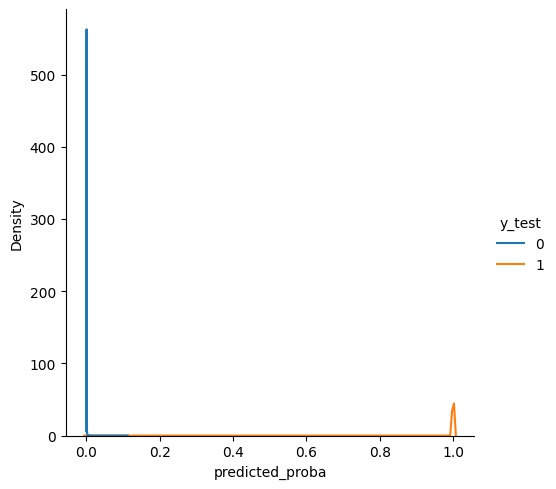

In [45]:
sns.displot(data= comp_df, x = "predicted_proba", hue="y_test", kind="kde")